In this notebook I have implemneted the Residual Attention Network on the cifar-10 dataset.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
def plot_10_by_10_images(images):

    # figure size
    fig = plt.figure(figsize=(30,30))

    # plot image grid
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+x+1)
            plt.imshow(images[10*y+x])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

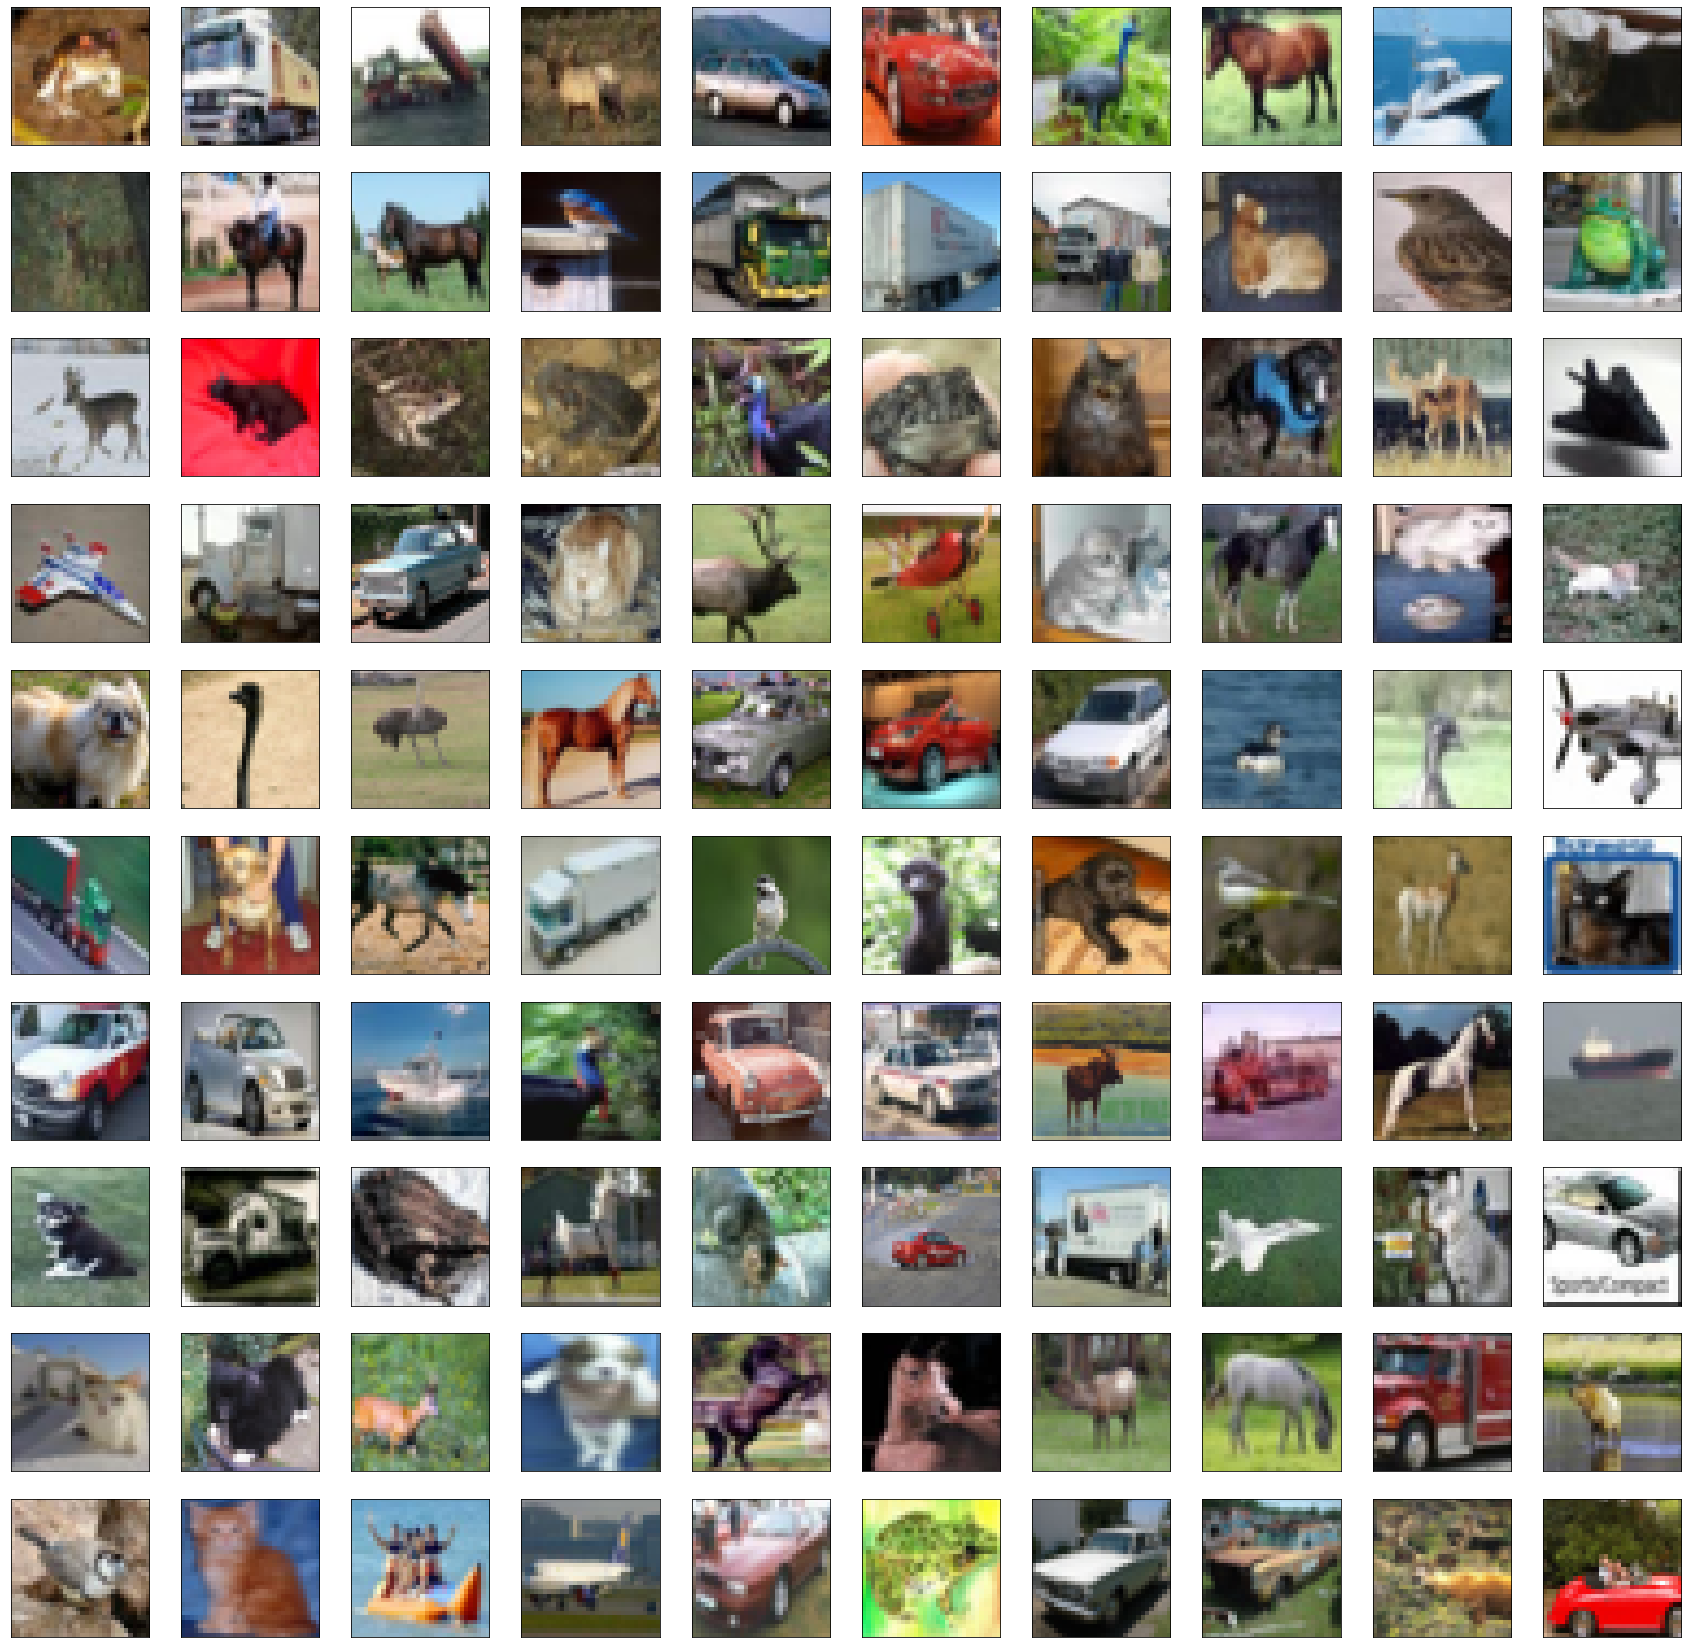

In [4]:
plot_10_by_10_images(x_train[:100])

In [5]:
from keras.layers import Input, Conv2D, Lambda, MaxPool2D, UpSampling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Activation, Flatten, Dense, Add, Multiply, BatchNormalization, Dropout

from keras.models import Model

In [6]:
class ResidualAttentionNetwork():

    def __init__(self, input_shape, n_classes, activation, p=1, t=2, r=1):
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.activation = activation
        self.p = p
        self.t = t
        self.r = r
        
    def build_model(self):
         # Initialize a Keras Tensor of input_shape
        input_data = Input(shape=self.input_shape)
        
        # Initial Layers before Attention Module
        
        # Doing padding because I'm having trouble with img dims that are <= 28
        if self.input_shape[0] <= 28 or self.input_shape[1] <= 28:
            x_dim_inc = (32 - self.input_shape[0]) // 2
            y_dim_inc = (32 - self.input_shape[1]) // 2
            
            # Pad the input data to 32x32
            padded_input_data = ZeroPadding2D( (x_dim_inc, y_dim_inc) )(input_data)
            conv_layer_1 = Conv2D(filters=32,
                             kernel_size=(3,3),
                             strides=(1,1),
                             padding='same')(padded_input_data)
        else:
            conv_layer_1 = Conv2D(filters=32,
                             kernel_size=(3,3),
                             strides=(1,1),
                             padding='same')(input_data)
        
        max_pool_layer_1 = MaxPool2D(pool_size=(2, 2), 
                                     strides=(2, 2),
                                     padding='same')(conv_layer_1)

        # Residual Unit then Attention Module #1
        res_unit_1 = self.residual_unit(max_pool_layer_1, filters=[32, 64, 128])
        att_mod_1 = self.attention_module(res_unit_1, filters=[32, 64, 128])
        
        # Residual Unit then Attention Module #2
        res_unit_2 = self.residual_unit(att_mod_1, filters=[32, 64, 128])
        att_mod_2 = self.attention_module(res_unit_2, filters=[32, 64, 128])

        # Residual Unit then Attention Module #3
        res_unit_3 = self.residual_unit(att_mod_2, filters=[32, 64, 128])
        att_mod_3 = self.attention_module(res_unit_3, filters=[32, 64, 128])

        # Ending it all
        res_unit_end_1 = self.residual_unit(att_mod_3, filters=[32, 32, 64])
        res_unit_end_2 = self.residual_unit(res_unit_end_1, filters=[32, 32, 64])
        res_unit_end_3 = self.residual_unit(res_unit_end_2, filters=[32, 32, 64])
        res_unit_end_4 = self.residual_unit(res_unit_end_3, filters=[32, 32, 64])

        # Avg Pooling
        avg_pool_layer = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(res_unit_end_4)

        # Flatten the data
        flatten_op = Flatten()(avg_pool_layer)

        # FC Layers for prediction
        fully_connected_layer_1 = Dense(256, activation='relu')(flatten_op)
        dropout_layer_1 = Dropout(0.5)(fully_connected_layer_1)
        fully_connected_layer_2 = Dense(256, activation='relu')(dropout_layer_1)
        dropout_layer_2 = Dropout(0.5)(fully_connected_layer_2)
        fully_connected_layer_3 = Dense(256, activation='relu')(dropout_layer_2)
        dropout_layer_3 = Dropout(0.5)(fully_connected_layer_3)
        fully_connected_layer_last = Dense(self.n_classes, activation=self.activation)(dropout_layer_3)
         
        # Fully constructed model
        model = Model(inputs=input_data, outputs=fully_connected_layer_last)
        
        return model

    # Pre-Activation Identity ResUnit Bottleneck Architecture
    def residual_unit(self, residual_input_data, filters):
        
        # Hold input_x here for later processing
        identity_x = residual_input_data
        
        filter1,filter2,filter3 = filters
        
        # Layer 1
        batch_norm_op_1 = BatchNormalization()(residual_input_data)
        activation_op_1 = Activation('relu')(batch_norm_op_1)
        conv_op_1 = Conv2D(filters=filter1,
                         kernel_size=(1,1),
                         strides=(1,1),
                         padding='same')(activation_op_1)
        
        # Layer 2
        batch_norm_op_2 = BatchNormalization()(conv_op_1)
        activation_op_2 = Activation('relu')(batch_norm_op_2)
        conv_op_2 = Conv2D(filters=filter2,
                         kernel_size=(3,3),
                         strides=(1,1),
                         padding='same')(activation_op_2)
    
        # Layer 3
        batch_norm_op_3 = BatchNormalization()(conv_op_2)
        activation_op_3 = Activation('relu')(batch_norm_op_3)
        conv_op_3 = Conv2D(filters=filter3,
                         kernel_size=(1,1),
                         strides=(1,1),
                         padding='same')(activation_op_3)
        
        # Element-wise Addition
        if identity_x.shape[-1] != conv_op_3.shape[-1]:
            filter_n = conv_op_3.shape[-1]
            
            identity_x = Conv2D(filters=filter_n,
                             kernel_size=(1,1),
                             strides=(1,1),
                             padding='same')(identity_x)
            
        output = Add()([identity_x, conv_op_3])

        return output

    def attention_module(self, attention_input_data, filters):
        # Send input_x through #p residual_units
        p_res_unit_op_1 = attention_input_data
        for _ in range(self.p):
            p_res_unit_op_1 = self.residual_unit(p_res_unit_op_1, filters=filters)

        # Perform Trunk Branch Operation
        trunk_branch_op = self.trunk_branch(trunk_input_data=p_res_unit_op_1, filters=filters)

        # Perform Mask Branch Operation
        mask_branch_op = self.mask_branch(mask_input_data=p_res_unit_op_1, filters=filters)

        # Perform Attention Residual Learning: Combine Trunk and Mask branch results
        ar_learning_op = self.attention_residual_learning(mask_input=mask_branch_op, trunk_input=trunk_branch_op)

        # Send branch results through #p residual_units
        p_res_unit_op_2 = ar_learning_op
        for _ in range(self.p):
            p_res_unit_op_2 = self.residual_unit(p_res_unit_op_2, filters=filters)

        return p_res_unit_op_2

    def trunk_branch(self, trunk_input_data, filters):
        # sequence of residual units, default=2
        t_res_unit_op = trunk_input_data
        for _ in range(self.t):
            t_res_unit_op = self.residual_unit(t_res_unit_op, filters=filters)

        return t_res_unit_op

    def mask_branch(self, mask_input_data, filters, m=3):
        # r = num of residual units between adjacent pooling layers, default=1
        # m = num max pooling / linear interpolations to do

        # Downsampling Step Initialization - Top
        downsampling = MaxPool2D(pool_size=(2, 2), 
                                     strides=(2, 2),
                                     padding='same')(mask_input_data)

        for _ in range(m):
            # Perform residual units ops r times between adjacent pooling layers
            for j in range(self.r):
                downsampling = self.residual_unit(residual_input_data=downsampling, filters=filters)

            # Last pooling step before middle step - Bottom
            downsampling = MaxPool2D(pool_size=(2, 2), 
                                         strides=(2, 2),
                                         padding='same')(downsampling)
        
        #===================================================================================================

        # Middle Residuals - Perform 2*r residual units steps before upsampling
        middleware = downsampling
        for _ in range(2 * self.r):
            middleware = self.residual_unit(residual_input_data=middleware, filters=filters)

        #===================================================================================================
        
        # Upsampling Step Initialization - Top
        upsampling = UpSampling2D(size=(2, 2))(middleware)

        for _ in range(m):
            # Perform residual units ops r times between adjacent pooling layers
            for j in range(self.r):
                upsampling = self.residual_unit(residual_input_data=upsampling, filters=filters)

            # Last interpolation step - Bottom
            upsampling = UpSampling2D(size=(2, 2))(upsampling)
        
        conv_filter = upsampling.shape[-1]
        
        conv1 = Conv2D(filters=conv_filter,
                         kernel_size=(1,1),
                         strides=(1,1),
                         padding='same')(upsampling)
        
        conv2 = Conv2D(filters=conv_filter,
                         kernel_size=(1,1),
                         strides=(1,1),
                         padding='same')(conv1)

        sigmoid = Activation('sigmoid')(conv2)

        return sigmoid

    def attention_residual_learning(self, mask_input, trunk_input):
        # https://stackoverflow.com/a/53361303/9221241
        Mx = Lambda(lambda x: 1 + x)(mask_input) # 1 + mask
        return Multiply()([Mx, trunk_input]) # M(x) * T(x)

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

import h5py

import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

In [8]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

batch_size=128

epochs = 50

In [9]:
from sklearn.model_selection import train_test_split
x_train, test_x, y_train, test_y = train_test_split(x_train, y_train, test_size = 0.25, random_state = 2019)

In [10]:
from tensorflow.keras.utils import to_categorical
train_datagen = ImageDataGenerator()
train_datagen.fit(x_train)
y_train = to_categorical(y_train)
test_y = to_categorical(test_y)
valid_datagen = ImageDataGenerator()
valid_datagen.fit(test_x)

In [11]:
STEP_SIZE_TRAIN=37500//128
STEP_SIZE_VALID=12500//128

Training on cifar-10 dataset with similar batch size, epoch and training and validation dataset as the Squeeze and Excitation Network

In [12]:
from tensorflow.keras.optimizers import Adam
model = ResidualAttentionNetwork((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 1, activation='sigmoid').build_model()

model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(generator=train_datagen.flow(x_train,y_train,batch_size=128),
                    steps_per_epoch=STEP_SIZE_TRAIN, verbose=1,
                    validation_data=valid_datagen.flow(test_x,test_y,batch_size=128), validation_steps=STEP_SIZE_VALID,
                    epochs=epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
292/292 [==============================] - 77s 165ms/step - loss: 3.6782 - accuracy: 0.8658 - val_loss: 0.5253 - val_accuracy: 0.9000
Epoch 2/50
292/292 [==============================] - 46s 158ms/step - loss: 0.4877 - accuracy: 0.8979 - val_loss: 0.4292 - val_accuracy: 0.9000
Epoch 3/50
292/292 [==============================] - 47s 160ms/step - loss: 0.4050 - accuracy: 0.8995 - val_loss: 0.3732 - val_accuracy: 0.9000
Epoch 4/50
292/292 [==============================] - 48s 163ms/step - loss: 0.3616 - accuracy: 0.8998 - val_loss: 0.3446 - val_accuracy: 0.9000
Epoch 5/50
292/292 [==============================] - 47s 162ms/step - loss: 0.3415 - accuracy: 0.9000 - val_loss: 0.3319 - val_accuracy: 0.9000
Epoch 6/50
292/292 [==============================] - 46s 158ms/step - loss: 0.3329 - accuracy: 0.9000 - val_loss: 0.3272 - val_accuracy: 0.9000
Epoch 7/50
292/292 [==============================] - 48s 163ms/step - loss: 0.3297 - accuracy: 0.9000 - val_loss: 0.3259 - val_ac

In [18]:
modelBlock = Model(inputs=model.inputs, outputs=model.layers[13].output)

Here to get one block of the model, I cropped the layers after 13

In [19]:
modelBlock.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         max_pooling2d[0][0]              
____________________________________________________________________________________________

I have additionally added the white channel here and couldn't remove it and re-run it due to time constraints. But you can see that there are 'attention-aware' features, where specific features related to the 'Frog' are highlighted. The same thing can be seen in the gray scale as well, Particularly in the final image in gray scale you can faintly see that the FROG is highlighted.

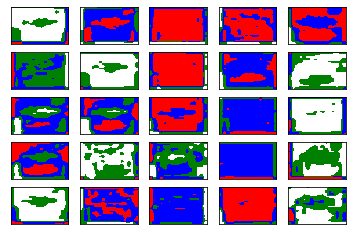

In [24]:
from matplotlib.colors import ListedColormap
from numpy import expand_dims
from tensorflow.keras.applications import imagenet_utils
from matplotlib import pyplot
test_image = x_train[0]
# images_list = []
# images_list.append(np.array(test_image))
# x = np.asarray(images_list)
x = expand_dims(test_image, axis=0)
x = imagenet_utils.preprocess_input(x, mode='tf')
feature_maps = modelBlock.predict(x)
#feature_maps.shape
cMap = ListedColormap(['white', 'green', 'blue','red'])
square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap=cMap, aspect='auto')
        ix += 1
# show the figure
pyplot.show()

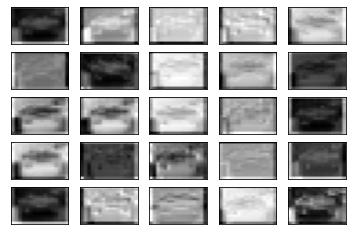

In [26]:
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray', aspect='auto')
        ix += 1
# show the figure
pyplot.show()